# Making predictions
Predicting artist gender and genre from song lyrics
A follow-up to [*Trucks and Beer*](http://www.johnwmillr.com/trucks-and-beer/), my textual analysis of 12k+ country song lyrics

---

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
import time
import re
from collections import Counter

fs = 16 # fontsize

---
## Load the data

In [2]:
songs = pd.read_json('./data/lyrics/all_songs.json')

In [3]:
artist = songs[songs.artist=='The Beatles']

In [4]:
artist.head()

,album,artist,gender,genre,image,lyrics,raw,title,year
34290,Let It Be,The Beatles,male,rock,https://images.genius.com/1f61e7c20f3ec7d82362...,Words are flowing out like endless rain into a...,"{'annotation_count': 13, 'api_path': '/songs/1...",Across the Universe,1969-12-12
34291,Help!,The Beatles,male,rock,https://images.genius.com/adbf27acc77a06acfa4a...,They're gonna put me in the movies\nThey're go...,"{'annotation_count': 5, 'api_path': '/songs/12...",Act Naturally,1965-08-06
34292,Sgt. Pepper's Lonely Hearts Club Band,The Beatles,male,rock,https://images.genius.com/0e36e5abf5d93b95a6d8...,"I read the news today, oh boy\nAbout a lucky m...","{'annotation_count': 17, 'api_path': '/songs/1...",A Day in the Life,1967-06-01
34293,A Hard Day's Night,The Beatles,male,rock,https://images.genius.com/68c11c7f5b6b66194d77...,It's been a hard day's night\nAnd I've been wo...,"{'annotation_count': 13, 'api_path': '/songs/1...",A Hard Day's Night,1964-07-10
34294,A Hard Day's Night,The Beatles,male,rock,https://images.genius.com/68c11c7f5b6b66194d77...,"Side 11. \t""A Hard Day's Night""\n2. \t""Tell Me...","{'annotation_count': 0, 'api_path': '/songs/14...",A Hard Day's Night (U.S. version),None


## Explore the data

At the start of any analysis, it's helpful to visualize the data and get a rough sense for how they behave.

For textual analyses, a few common metrics are `words_per_sample` and `word_frequency_distributions`

In [5]:
genres = songs.genre.unique()
print(genres)

['rap' 'rock' 'country']


In [237]:
import nltk
from nltk.corpus import stopwords
from string import punctuation
punctuation = "".join([symbol for symbol in punctuation if symbol not in ["'", '"']])

# We'll use these helper functions throughout the analysis
def clean_str(s):
    return s.translate(str.maketrans('', '', punctuation)).replace('\u200b', " ").strip().lower()

def tokenizeText(txt, remove_stop_words=False):
    """Splits a string of text into individual words"""
    stop_words = set(stopwords.words('english')) if remove_stop_words else []
    words = [w for w in clean_str(txt).split() if w not in stop_words]
    return words

#     regex = re.compile(r"\w+(?:[-']\w+)*|'|[-.(]+|\S\w*", re.IGNORECASE)
#     return regex.findall(txt)

### `words_per_song`
In this analysis, each individual song can be considered a 'sample', i.e. `words_per_song` is equivalent to `words_per_sample`

In [9]:
# Calculate words per song (i.e. sample) by genre
def calcNumWordsInText(txt, remove_stop_words=True):
    """Return the number of words in a sample of text"""        
    stop_words = set(stopwords.words('english')) if remove_stop_words else []
    words = tokenizeText(txt)
    return len([w for w in words if w not in stop_words])
        
words_per_song = {}
for genre in genres:    
    words_per_song[genre] = np.array([calcNumWordsInText(s, False) for s in songs[songs.genre==genre].lyrics])

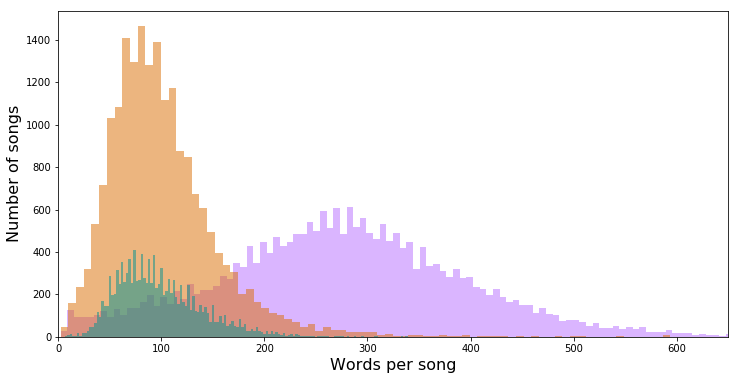

In [10]:
# Words per song by genre
fig, ax = plt.subplots(figsize=(12, 6))
colors = np.array([(182,109,255),(218,109,0),(0,146,146)])/255
for genre, color in zip(genres, colors):
    plt.hist(words_per_song[genre], 1000, color=color, alpha=0.5)
    
ax.set_xlim([0, 650])
ax.set_xlabel("Words per song", fontsize=fs)
ax.set_ylabel("Number of songs", fontsize=fs)
plt.show()

***Class Imbalance***

This histogram also shows us that we have a bit of a class imbalance. There are about 20k song lyrics for rap and rock, but only 12k for country. If the number of samples between classes is too imbalanced when training a model, there's a risk the model will be improperly biased towards predicting certain genres over others. I don't think we have too bad of an imbalance, so I'm hoping we don't need to address the issue now.

However, going forward, it may be helpful to account for this imbalance in our visualizations. One simple step we can use with the `plt.hist` command is to set the `density` option to `True`.

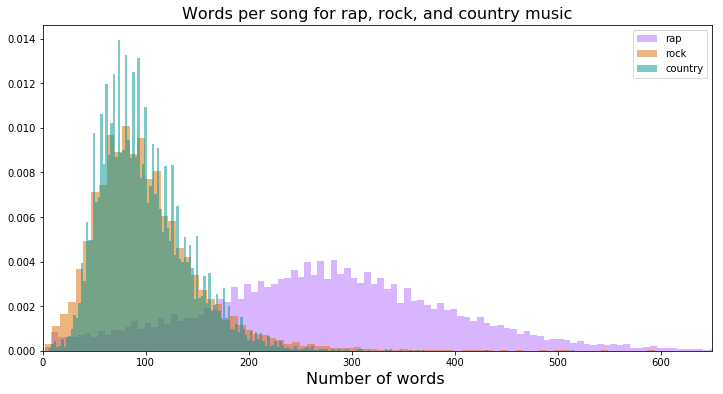

In [11]:
# Words per song by genre
fig, ax = plt.subplots(figsize=(12, 6))
for genre, color in zip(genres, colors):
    plt.hist(words_per_song[genre], 1000, color=color, alpha=0.5, density=True, label=genre)
    
ax.set_xlim([0, 650])
ax.set_xlabel("Number of words ", fontsize=fs)
ax.set_title("Words per song for rap, rock, and country music", fontsize=fs)
ax.legend()
plt.show()

### `word_frequency_distributions`

In [12]:
from sklearn.feature_extraction.text import CountVectorizer

In [13]:
# What are the most popular words for each genre?
def plot_freq_dist(sample_texts,
                   ngram_range=(1, 2),
                  num_ngrams=50,
                  mfeats=None,
                  color='b'):
    """Plots the frequency distribution of n-grams.
    # Arguments
        samples_texts: list, sample texts.
        ngram_range: tuple (min, mplt), The range of n-gram values to consider.
            Min and mplt are the lower and upper bound values for the range.
        num_ngrams: int, number of n-grams to plot.
            Top `num_ngrams` frequent n-grams will be plotted.
    https://developers.google.com/machine-learning/guides/text-classification/step-2
    """
    
    # TEMPORARY - Shorten the list of texts
#     sample_texts = sample_texts[:1000]
    
    # Create args required for vectorizing.
    kwargs = {
            'ngram_range': (1, 1),
            'dtype': 'int32',
            'strip_accents': 'unicode',
            'decode_error': 'replace',
            'max_features': mfeats,
            'analyzer': 'word',  # Split text into word tokens.
            'tokenizer': tokenizeText, # Custom tokenizer
    }
    vectorizer = CountVectorizer(**kwargs)
    vectorized_texts = vectorizer.fit_transform(sample_texts)

    # This is the list of all n-grams in the index order from the vocabulary.
    all_ngrams = list(vectorizer.get_feature_names())
    num_ngrams = min(num_ngrams, len(all_ngrams))

    # Add up the counts per n-gram ie. column-wise
    all_counts = vectorized_texts.sum(axis=0).tolist()[0]

    # Sort n-grams and counts by frequency and get top `num_ngrams` ngrams.
    all_counts, all_ngrams = zip(*[(c, n) for c, n in sorted(
        zip(all_counts, all_ngrams), reverse=True)])
    ngrams = list(all_ngrams)[:num_ngrams]
    counts = list(all_counts)[:num_ngrams]
        
    # Make the graph
    idx = np.arange(num_ngrams)
    fig, ax = plt.subplots(figsize=(14,4))
    ax.bar(idx, counts, width=0.8, color=color, alpha=0.5)
    ax.set_ylabel('Frequencies')    
    plt.xticks(idx, ngrams, rotation=45)

Using the (slightly modified) code above taken from a [Google tutorial](https://developers.google.com/machine-learning/guides/text-classification/step-2) on text analysis, we can easily look at the ten most frequent words for each of the three genres.

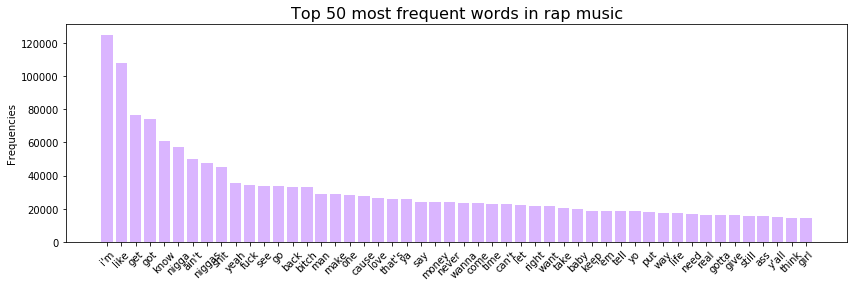

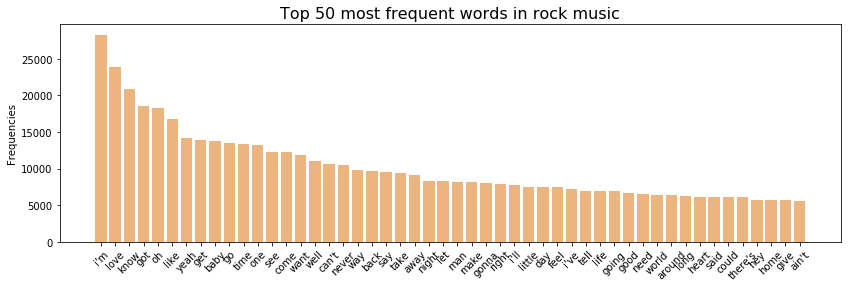

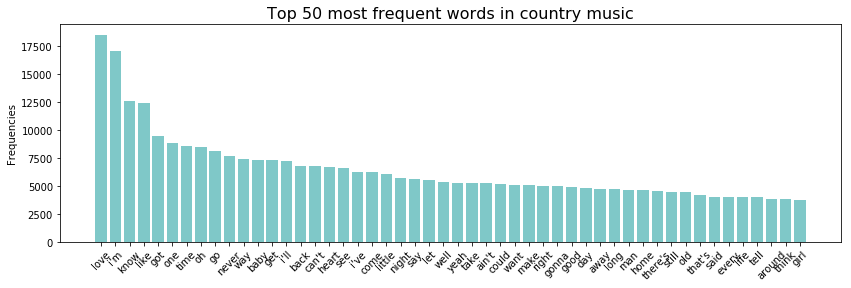

In [98]:
# Plot the most frequent words for each genre
mf = 50 # number of words to plot
for g, c in zip(genres, colors):
    plot_freq_dist(songs[songs.genre==g].lyrics, color=c, mfeats=mf)
    plt.title(f'Top {mf} most frequent words in {g} music', fontsize=fs)

### Section summary
By making these preliminary visualizations, we begin to get a sense for what features may be useful for differentiating between genres. For example, it looks like `words_per_song` may be helpful for identifying **rap** songs, but won't be all that useful for distinguishing between **rock** and **country** lyrics.

## Data Preparation

### Vectorization
We need to convert the raw text into numbers. We'll do this in two steps:
  1. Tokenization
  2. Encoding

### Word embedding

### TF-IDF
I want a function that takes two inputs:
  - Text of interest (e.g. rap lyrics)
  - Full corpus (e.g. rap, rock, country lyrics)
  
and outputs the TF-IDF scores for the 100 terms with the highest TF-IDF scores

In [54]:
def calcTFIDF(corpus, txt, term):
    """Return the tf-idf scores for a term in a text"""
    # Tokenize the corpus and text of interest
    
#     tmp = list(map(tokenizeText, corpus))
#     tok_corpus = []
#     for item in tmp:
#         tok_corpus.extend(item)
        
    doc_count = 0
    for doc in corpus:
        if term in doc:
            doc_count += 1
    
    tmp = list(map(tokenizeText, txt))
    tok_txt = []
    for item in tmp:
        tok_txt.extend(item)
        
    assert doc_count > 0, f"Term '{term}' not found in corpus."
#     print(tok_txt.count(term))
#     print(doc_count)
    return tok_txt.count(term) / doc_count

In [14]:
# Create a small corpus for quick testing
n = 10000
small_songs = pd.concat([songs[songs.genre==genre].sample(n) for genre in genres])
subset_rap = songs[songs.genre=='rap'].sample(n)
subset_rock = songs[songs.genre=='rock'].sample(n)
subset_country = songs[songs.genre=='country'].sample(n)

In [15]:
small_songs.head(2)

,album,artist,gender,genre,image,lyrics,raw,title,year
7811,None,Big Pun,male,rap,https://images.genius.com/b245dff946be15239da7...,Ay-yo my murderous rap verbal attack is actual...,"{'annotation_count': 5, 'api_path': '/songs/38...",Hot 97 freestyle,None
242,Gang Related - The Soundtrack,2Pac,male,rap,https://images.genius.com/7893982cf65937e95b38...,"'Cause I hate to spend my life, my life, my li...","{'annotation_count': 10, 'api_path': '/songs/6...",Lost Souls,1997-10-07


In [95]:
# Sanity check the TF-IDF function
for term in ['beer', 'truck', 'girl', 'love', 'like', 'nigga']:
    print(30*'-')
    for subset in [subset_rap, subset_rock, subset_country]:
        tfidf = calcTFIDF(small_songs.lyrics, subset.lyrics, term)
        genre = subset.genre.iloc[0][:3]
        print(f"The TF-IDF score for '{term}' in {genre} music is: {tfidf:.3f}")

------------------------------
The TF-IDF score for 'beer' in rap music is: 0.300
The TF-IDF score for 'beer' in roc music is: 0.210
The TF-IDF score for 'beer' in cou music is: 1.074
------------------------------
The TF-IDF score for 'truck' in rap music is: 0.570
The TF-IDF score for 'truck' in roc music is: 0.050
The TF-IDF score for 'truck' in cou music is: 0.426
------------------------------
The TF-IDF score for 'girl' in rap music is: 1.122
The TF-IDF score for 'girl' in roc music is: 0.519
The TF-IDF score for 'girl' in cou music is: 0.549
------------------------------
The TF-IDF score for 'love' in rap music is: 0.846
The TF-IDF score for 'love' in roc music is: 0.941
The TF-IDF score for 'love' in cou music is: 1.109
------------------------------
The TF-IDF score for 'like' in rap music is: 3.014
The TF-IDF score for 'like' in roc music is: 0.566
The TF-IDF score for 'like' in cou music is: 0.638
------------------------------
The TF-IDF score for 'nigga' in rap music is: 

In [102]:
tmp = list(map(tokenizeText, small_songs[small_songs.genre=='rap'].lyrics))
tokens = []
for item in tmp:
    tokens.extend(item)

In [108]:
100*len(set(tokens))/len(tokens)

3.3072071368198253

In [109]:
tmp = list(map(tokenizeText, small_songs[small_songs.genre=='country'].lyrics))
tokens = []
for item in tmp:
    tokens.extend(item)

In [110]:
100*len(set(tokens))/len(tokens)

2.7344686487958096

## gensim -- word2vec

In [ ]:
from gensim.models import Word2Vec

In [125]:
sentences = list(map(tokenizeText, small_songs[small_songs.genre=='rap'].lyrics))
model = Word2Vec(sentences, min_count=1)

In [132]:
model.train(sentences, total_examples=model.corpus_count, epochs=model.epochs)  # train word vectors

(12834931, 14079100)

In [133]:
model.save('wv_rap.model')

### Classification with NLTK

In [8]:
import random

In [9]:
# Create a subset of country and rap songs
n = 5000
tmp = []
for genre in ['rap', 'country']:
    tmp.append(songs[songs.genre==genre].sample(n))
subset = pd.concat(tmp)

In [10]:
# Tokenize the training text
song_tokens = list(map(tokenizeText, subset.lyrics))
tokens = [word for song in song_tokens for word in song]
fd = nltk.FreqDist(tokens)
n_features = 500
word_features = [word for word, count in fd.most_common(n_features)]

# Format the training data with genre labels
documents = [(tokens, genre) for tokens, genre in zip(song_tokens, subset.genre)]
random.shuffle(documents)

# Extract features from a list of words
def document_features(document):
    document_words = set(document)
    features = {}
    for word in word_features:
        features['contains({})'.format(word)] = (word in document_words)
    return features

In [27]:
# Train the classifier
featuresets = [(document_features(d), c) for (d,c) in documents]
idx_split = int(0.7 * len(featuresets))
train_set, test_set = featuresets[:idx_split], featuresets[idx_split:]
classifier = nltk.NaiveBayesClassifier.train(train_set)

In [28]:
print(nltk.classify.accuracy(classifier, test_set))

0.9386666666666666


In [259]:
print(songs.loc[0, 'lyrics'])

Death Row
That's where mothafuckas is endin' up

Dear Mama, I'm caught up in this sickness
I robbed my adversaries but slipped and left a witness
Wonder if they'll catch me or will this nigga snitch?
Should I shoot his bitch or make the nigga rich?
Don't wanna commit murder, but damn, they got me trapped
Hawkin' while I'm walkin' and talkin' behind my back
I'm kind of schizophrenic, I'm in this shit to win it
‘Cause life's a Wheel of Fortune, here's my chance to spin it
Got no time for cops who trip and try to catch me
Too fuckin' trigger-happy to let them suckers snatch me
Niggas gettin' jealous, tryin' to find my stash
Whip out the 9, now  pump yo' ass
Peter picked a pepper, but I can pick a punk
Snatched him like a bitch and threw him in the trunk
The punk thought I was bluffin', but swear I'm nothin' nice
Before I take your life, first wrestle with these mites
I listened to his screams until he went insane
I guess the little mites had finally found his brain
New Rovers pull me over

In [258]:
classifier.classify(document_features(tokenizeText(songs.loc[0, 'lyrics'])))

'rap'

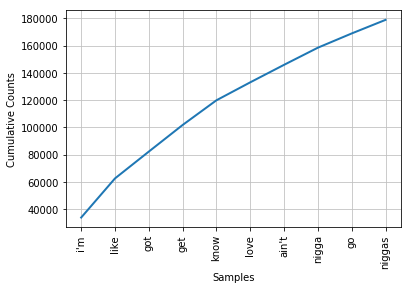

In [257]:
fd.plot(10, cumulative=True)

In [256]:
classifier.show_most_informative_features(10)

Most Informative Features
       contains(bitches) = True              rap : countr =    591.2 : 1.0
           contains(rap) = True              rap : countr =    450.6 : 1.0
         contains(i'mma) = True              rap : countr =    345.6 : 1.0
       contains(fucking) = True              rap : countr =    334.4 : 1.0
          contains(gon') = True              rap : countr =    211.2 : 1.0
          contains(shit) = True              rap : countr =    197.6 : 1.0
         contains(bitch) = True              rap : countr =    178.9 : 1.0
            contains(ho) = True              rap : countr =    154.7 : 1.0
         contains(gucci) = True              rap : countr =    151.5 : 1.0
          contains(dope) = True              rap : countr =    146.0 : 1.0


## Feature Extraction with sklearn

In [178]:
from sklearn.feature_extraction.text import CountVectorizer

In [238]:
bigram_vectorizer = CountVectorizer(ngram_range=(1, 2), min_df=1, tokenizer=tokenizeText)
bigram_analyze = bigram_vectorizer.build_analyzer()

In [240]:
bigram_analyze(songs.loc[0, 'lyrics'])

['death',
 'row',
 "that's",
 'where',
 'mothafuckas',
 'is',
 "endin'",
 'up',
 'dear',
 'mama',
 "i'm",
 'caught',
 'up',
 'in',
 'this',
 'sickness',
 'i',
 'robbed',
 'my',
 'adversaries',
 'but',
 'slipped',
 'and',
 'left',
 'a',
 'witness',
 'wonder',
 'if',
 "they'll",
 'catch',
 'me',
 'or',
 'will',
 'this',
 'nigga',
 'snitch',
 'should',
 'i',
 'shoot',
 'his',
 'bitch',
 'or',
 'make',
 'the',
 'nigga',
 'rich',
 "don't",
 'wanna',
 'commit',
 'murder',
 'but',
 'damn',
 'they',
 'got',
 'me',
 'trapped',
 "hawkin'",
 'while',
 "i'm",
 "walkin'",
 'and',
 "talkin'",
 'behind',
 'my',
 'back',
 "i'm",
 'kind',
 'of',
 'schizophrenic',
 "i'm",
 'in',
 'this',
 'shit',
 'to',
 'win',
 'it',
 '‘cause',
 "life's",
 'a',
 'wheel',
 'of',
 'fortune',
 "here's",
 'my',
 'chance',
 'to',
 'spin',
 'it',
 'got',
 'no',
 'time',
 'for',
 'cops',
 'who',
 'trip',
 'and',
 'try',
 'to',
 'catch',
 'me',
 'too',
 "fuckin'",
 'triggerhappy',
 'to',
 'let',
 'them',
 'suckers',
 'snatch',

### Creating a lyrics corpus
As we're hoping to classify rap and country songs, it'd be convenient to create a subset of lyrics that is cleaned up and ready to use for training and testing our model. Once we're happy with the model parameters, we can train and test the model on the entire dataset

In [343]:
# Create a subset of randomly sampled country and rap songs
n = 250
tmp = []
for genre in ['rap', 'country']:
    tmp.append(songs[songs.genre==genre].sample(n))
subset = pd.concat(tmp)

# Create the lyrics corpus with genre and index labels
corpus = []
for lyrics, genre, index in zip(subset.lyrics, subset.genre, subset.index):
    corpus.append((lyrics, genre, index))
random.shuffle(corpus)

In [351]:
X = bigram_vectorizer.fit_transform([doc[0] for doc in corpus]).toarray()
X.shape

(500, 92551)

In [352]:
X

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

### TF-IDF with Scikitlearn

In [280]:
from sklearn.feature_extraction.text import TfidfTransformer
transformer = TfidfTransformer(smooth_idf=False)
transformer  

TfidfTransformer(norm='l2', smooth_idf=False, sublinear_tf=False,
         use_idf=True)

In [353]:
# counts = [[3, 0, 1],
#           [2, 0, 0],
#           [3, 0, 0],
#           [4, 0, 0],
#           [3, 2, 0],
#           [3, 0, 2]]

counts = X.copy()
tfidf = transformer.fit_transform(counts)
tfidf                         

# tfidf.toarray()  

<500x92551 sparse matrix of type '<class 'numpy.float64'>'
	with 212391 stored elements in Compressed Sparse Row format>

In [356]:
np.unique(tfidf.toarray())

array([0.        , 0.00159373, 0.00164575, ..., 0.75001679, 0.78151628,
       0.81001107])

Luckily, `tf-idf` text processing is common enough that `scikit-learn` provides a single class that combines both vectorization and transformation

In [282]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [357]:
vectorizer = TfidfVectorizer()
vectorizer.fit_transform([song[0] for song in corpus])

<500x11612 sparse matrix of type '<class 'numpy.float64'>'
	with 75749 stored elements in Compressed Sparse Row format>

In [358]:
# Feature names
feature_names = np.asarray(vectorizer.get_feature_names())

## Train a classifier
We'll start by training a random forest classifier, a robust model that should provide quite good accuracy without too much fiddling with hyperparameters.

In [298]:
from sklearn.ensemble import RandomForestClassifier

### Prepare the training and testing data
Before we can train the the model we need to prepare a set of training and testing data.

In [377]:
a,b = zip(*[(song[1], song[2]) for song in corpus[:3]])

In [382]:
# The corpus was shuffled upon creation, so it's okay to separate train/test sequentially
idx_split = int(0.70 * len(corpus))
X_train, y_train = zip(*[(analyze(song[0]), song[1]) for song in corpus[:3]])

In [299]:
clf = RandomForestClassifier(n_estimators=50)

In [ ]:
clf.fit

---
## Notes

I could frame this post in part as an extension of this [Pudding piece](https://pudding.cool/2017/09/hip-hop-words/) on the most typical hip-hop words. They identified words that were unique to different genres, but didn't use that information to *train a classifier*

I should compare my performance to other papers:
  - https://arxiv.org/abs/1707.04678
  - https://nlp.stanford.edu/courses/cs224n/2006/fp/sadovsky-x1n9-1-224n_final_report.pdf
  - https://github.com/ianscottknight/Musical-Genre-Classification-of-Song-Lyrics

sklearn tutorial on optimizing the classifier hyperparameter tuning: http://scikit-learn.org/stable/auto_examples/model_selection/grid_search_text_feature_extraction.html#sphx-glr-auto-examples-model-selection-grid-search-text-feature-extraction-py

# Review
 - What features are most useful for classifying genre? And for gender?

In [255]:
X.shape

(501, 117032)

In [249]:
C = X

In [248]:
F = X.copy()

In [250]:
del(X)